# Global PCA model training

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tikzplotlib
import random
import ast
from nltk.corpus import stopwords
from gensim.utils import tokenize
from lyrics_stats import lyrics_statistics
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import joblib
from gensim.models.doc2vec import Doc2Vec
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

2023-02-12 19:11:03.784985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-02-12 19:11:05.551138: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-12 19:11:05.551358: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-12 19:11:05.551369: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
sns.set_theme(context='paper', style='white', palette='deep')

In [3]:
df = pd.read_csv('../data/lyrics.csv')

In [4]:
df.head()

,lyrics,genre,id
0,"['I feel so unsure', 'As I take your hand and ...",pop,0
1,"[""Don't let them fool, ya"", 'Or even try to sc...",pop,1
2,"[""Baby, let's cruise, away from here"", ""Don't ...",pop,2
3,"['Know it sounds funny', ""But, I just can't st...",pop,3
4,"[""You've got that look again"", 'The one I hope...",pop,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54350 entries, 0 to 54349
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lyrics  54350 non-null  object
 1   genre   54350 non-null  object
 2   id      54350 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [6]:
df['lyrics'] = list(map(lambda x: ast.literal_eval(x), df['lyrics']))

In [7]:
idxs_eval = pd.read_csv('../data/evaluation/lyrics_eval.csv')['id']
idxs_test = pd.read_csv('../data/classification/lyrics_test.csv')['id']

In [8]:
indexes2delete = list(idxs_eval) + list(idxs_test)

In [9]:
df = df.drop(indexes2delete)
df = df.reset_index()

In [10]:
lyrics = list(df['lyrics'])
genres = list(df['genre'])

verses = [verse for lyr in lyrics for verse in lyr]
genres_by_verse = [genre for lyr, genre in zip(lyrics, genres) for verse in lyr]

lyrics_indexes = [i for i, lyr in enumerate(lyrics) for verse in lyr]
verse_indexes = [i for lyr in lyrics for i, verse in enumerate(lyr)]

verse_df = pd.DataFrame({'verse': verses, 'genre': genres_by_verse, 
                         'lyrics_id': lyrics_indexes, 'verse_id': verse_indexes})

verse_df = verse_df.groupby('genre').sample(frac=0.05, random_state=42).reset_index()
#verse_df = verse_df.groupby('genre').sample(n=25, random_state=42).reset_index()

In [11]:
verse_df.head()

,index,verse,genre,lyrics_id,verse_id
0,291628,And you don't need nobody home,pop,4286,16
1,1404520,I can hardly wait for the day when we say I do.,pop,26214,12
2,754871,Wondering where it had to go,pop,14404,9
3,481108,I need you to love me,pop,8480,17
4,569679,About you and me,pop,10298,29


## Features

In [12]:
# Get features from a specific verse based on its index in the lyrics
get_features_verse = lambda x, index: [v[index] for v in x.values()]

# Compute lyrics statistics of lyrics with index_id i, get verse statistics from verse_id j
features_by_verse = [get_features_verse(lyrics_statistics(df['lyrics'][row['lyrics_id']]), row['verse_id']) 
                    for index, row in verse_df.iterrows()]

features_by_verse = np.array(features_by_verse)

In [13]:
scaler = StandardScaler()
scl_features_by_verse = scaler.fit_transform(np.array(features_by_verse))

In [14]:
pca = PCA(n_components=1, random_state=42)
pca.fit(scl_features_by_verse)

PCA(n_components=1, random_state=42)

In [15]:
joblib.dump(pca, '../models/features_pca.pkl')
joblib.dump(scaler, '../models/features_scaler.pkl')

['../models/features_scaler.pkl']

In [16]:
scaler = joblib.load('../models/features_scaler.pkl')
pca = joblib.load('../models/features_pca.pkl')

["Bitches ain't shit and they ain't say nothing", "A hundred motherfuckers can't tell me nothing", 'A beez in the trap, bee beez in the trap', 'A beez in the trap, bee beez in the trap', "Bitches ain't shit and they ain't say nothing", "A hundred motherfuckers can't tell me nothing", 'A beez in the trap, bee beez in the trap', 'A beez in the trap, bee beez in the trap', 'Man, I been did that, man, I been popped off', "And if she ain't trying to give it then she get dropped off", 'Let me bust that u-ie, bitch bust that open', "Might spend a couple thou' just to bust that open", 'Rip it off no joking, like your name hulk hogan', "Nigga's move weight and sell but live in hoboken", "I spit that crack, like I'm in that trap", "So if you need a hit then I'm with that bat", "Bitches ain't shit and they ain't say nothing", "A hundred motherfuckers can't tell me nothing", 'A beez in the trap, bee beez in the trap', 'A beez in the trap, bee beez in the trap', "Bitches ain't shit and they ain't s

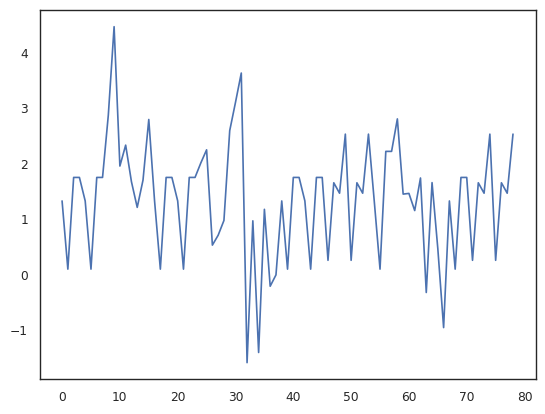

In [17]:
random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

eg_multi_ts = pd.DataFrame(lyrics_statistics(random_lyrics)).values
eg_scl_multi_ts = scaler.transform(eg_multi_ts)
eg_uni_ts = list(
    map(lambda unique_element: unique_element[0], pca.transform(eg_scl_multi_ts)))
plt.plot(eg_uni_ts)

## Sentence BERT

In [18]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [19]:
embeddings = [model.encode([verse]) for verse in verse_df['verse']]

embeddings = np.concatenate(embeddings, axis=0)

In [20]:
pca = PCA(n_components=1, random_state=42)
pca.fit(embeddings)

PCA(n_components=1, random_state=42)

In [21]:
joblib.dump(pca, '../models/sbert_pca.pkl')

['../models/sbert_pca.pkl']

In [22]:
pca = joblib.load('../models/sbert_pca.pkl')

['Sometimes life just makes it hard for me to breathe', 'Sometimes life just makes it hard for me to breathe', "'When the good turns into bad", 'And the happy into sad', 'When the weight of this big world', 'Is too much for this small girl', 'And I gotta find a way', 'Just to make it through the day', "So I left my hand I'm safe", "Everything will be okay, babe'", 'Oooh the tears from your eyes dance in the rain from the sky', 'Get yourself high', 'Ooooh the tears from your eyes dance in the rain from the sky', 'Get yourself high', 'Sometimes life just makes it hard for me to breathe', 'Sometimes life just makes it hard for me to breathe', "'When the good turns into bad", 'And the happy into sad', 'When the weight of this big world', 'Is too much for this small girl', 'And I gotta find a way', 'Just to make it through the day', "So I left my hand I'm safe", "Everything will be okay, babe'", 'Oooh the tears from your eyes dance in the rain from the sky', 'Get yourself high', 'Ooooh the 

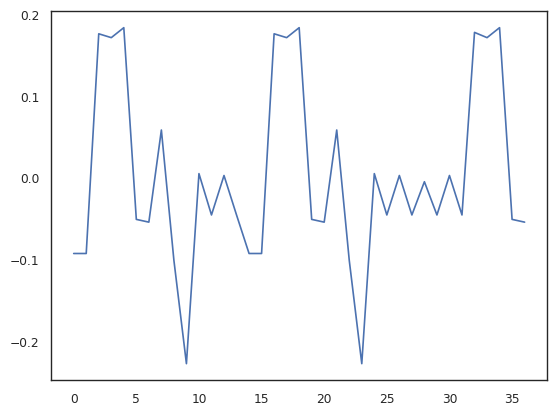

In [23]:
# Generate a multivariate time series for text as a sequence of sentence embedding (SBERT)
generate_multi_ts = lambda lyrics, model: np.array([model.encode(verse) for verse in lyrics])

random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

eg_multi_ts = generate_multi_ts(random_lyrics, model)
eg_uni_ts = list(
    map(lambda unique_element: unique_element[0], pca.transform(eg_multi_ts)))
plt.plot(eg_uni_ts)

## Doc2Vec

In [24]:
model = Doc2Vec.load("../models/doc2vec.model")

In [25]:
def tokenize_verse(verse, remove_stop_words=True):
    tokens = list(tokenize(verse, lowercase=True))
    if remove_stop_words:
        stop_words = stopwords.words('english')
        tokens = [token for token in tokens if token not in stop_words]    
    return tokens

In [26]:
tokenized_verses = [tokenize_verse(verse) for verse in verse_df['verse']]

In [27]:
embeddings = np.array([model.infer_vector(verse) for verse in tokenized_verses if verse])

In [28]:
scaler = StandardScaler()
scl_embeddings = scaler.fit_transform(np.array(embeddings))

In [29]:
pca = PCA(n_components=1, random_state=42)
pca.fit(scl_embeddings)

PCA(n_components=1, random_state=42)

In [30]:
joblib.dump(pca, '../models/d2v_pca.pkl')
joblib.dump(scaler, '../models/d2v_scaler.pkl')

['../models/d2v_scaler.pkl']

In [31]:
scaler = joblib.load('../models/d2v_scaler.pkl')
pca = joblib.load('../models/d2v_pca.pkl')

['Okay, thought about it for a minute', "Can't let love go spinnin' down the drain now", "You're my homie, baby you're my homie", 'Simple math, pen & pad; gotta work out', "You're my homie, baby you're my homie", "But you're my only, baby you're my only", "Just grab a pencil, don't you wanna help out", "It can't be hard", 'Gotta find the answers to the problem', "Ain't no answers here without you, no", "Been writin' all day, fillin' my page", "Tryna fix this, wrackin' my brain", 'No love still ', "Been writin' all day, tryna work it out", "Waiting on you, can't do it by myself", 'No love still ', 'No love', "Okay, I'm gonna tell you everything", 'The whole truth, not fractions of a bad lie', "You're my homie, baby you're my only", "She's the past, she's my future, my right now", "You're my homie, baby you're my homie", "And I'm sorry, girl you gotta know it", 'Grab a seat, just try to hear me out boy', "I know it's hard", "Wish I could use a calculator, but it won't even work", "Can't 

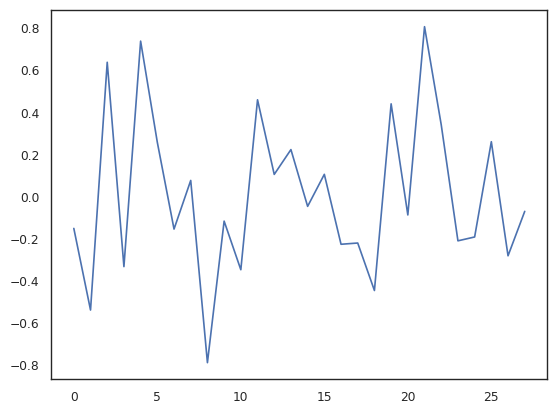

In [32]:
# Generate a multivariate time series for text as a sequence of sentence embedding (Doc2Vec)
generate_multi_ts = lambda lyrics, model: np.array([model.infer_vector(verse) for verse in lyrics])

random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

tokenized_lyrics = list(map(lambda x: tokenize_verse(x), random_lyrics))
eg_multi_ts = generate_multi_ts(tokenized_lyrics, model)
eg_uni_ts = list(
    map(lambda unique_element: unique_element[0], pca.transform(eg_multi_ts)))
plt.plot(eg_uni_ts)

## Emotion

In [33]:
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")

model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base", output_hidden_states = False)

In [34]:
def get_logits(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits    
    return logits

In [35]:
def logits2label(logits, model):
    predicted_class_id = logits.argmax().item()
    label = model.config.id2label[predicted_class_id]
    return label

In [36]:
logits_tensor = [get_logits(verse, tokenizer=tokenizer, model=model) for verse in list(verse_df['verse'])]

In [37]:
# Convert tensors to numpy array
logits = np.array([lt[0].numpy() for lt in logits_tensor])
labels = [logits2label(lt, model) for lt in logits_tensor]

In [38]:
tsne_model = TSNE(n_components=2, random_state=42, init='pca')

In [39]:
tsne_logits = pd.DataFrame(tsne_model.fit_transform(logits), columns=['x','y'])
tsne_logits['label'] = labels

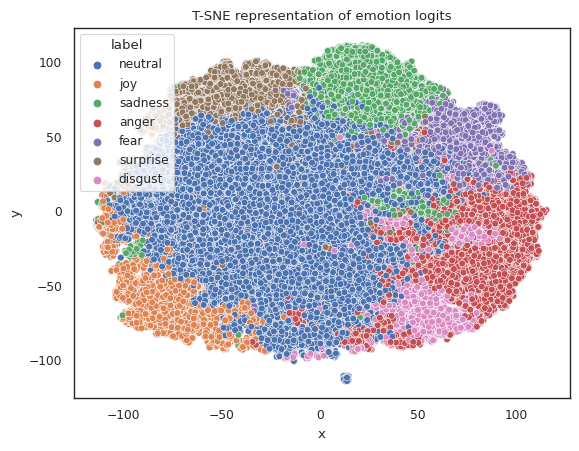

In [40]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data=tsne_logits, x='x', y='y', hue='label')
ax.set_title('T-SNE representation of emotion logits')
tikzplotlib.save('../tikz/tsne_emotions.tex')

In [41]:
scaler = StandardScaler()
scl_logits = scaler.fit_transform(logits)

In [42]:
pca = PCA(n_components=1, random_state=42)
pca.fit(scl_logits)

PCA(n_components=1, random_state=42)

In [43]:
joblib.dump(pca, '../models/emo_pca.pkl')
joblib.dump(scaler, '../models/emo_scaler.pkl')

['../models/emo_scaler.pkl']

In [44]:
scaler = joblib.load('../models/emo_scaler.pkl')
pca = joblib.load('../models/emo_pca.pkl')

['Things you said to me', 'Sentimentally', 'Are always on my mind.', 'Seems you haunted me', 'But you set me free', 'Long before you gave me time to escape.', 'The next time', "I'll be on my way", "'Cause it's time, it's true", "I'm turning my back on you.", "Don't ya say it,", "Don't say you need me", "You don't need me,", "Don't even try.", "Don't ya say it,", "Don't say you want me,", "You don't mean it,", "Don't say good-bye.", 'You threw love at me', "Indispensab'ly,", 'But you never could give it away.', 'And it seems to me', "That you'd never be,", "That's why I'll never stay with you.", "You can't hold me down", "'Cause it's my life too,", "So this time it's true,", "I'm turning my back on you", "Don't ya say it,", "Don't say you want me,", "You don't mean it,", "Don't even try.", "Don't ya say it,", "Don't say you need me,", "You don't mean it,", "Don't say good-bye.", "Don't ya say it,", "Don't say you need me,", "You don't need me,", "Don't even try.", "Don't ya say it,", "D

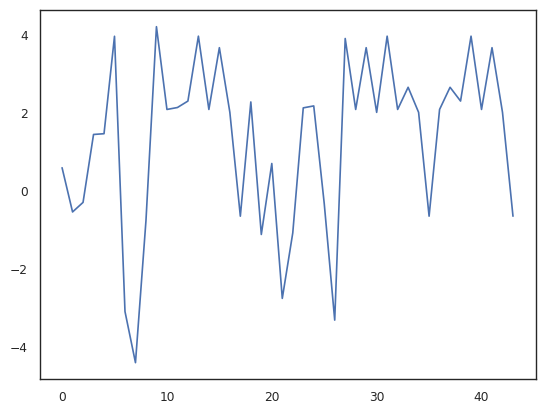

In [45]:
random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

logits_tensor = [get_logits(verse, tokenizer=tokenizer, model=model) for verse in random_lyrics]

# Convert tensors to numpy array
eg_multi_ts = np.array([lt[0].numpy() for lt in logits_tensor])
eg_uni_ts = list(
    map(lambda unique_element: unique_element[0], pca.transform(eg_multi_ts)))
plt.plot(eg_uni_ts)